---
title: Exploratory Data Analysis
description: ...
---

### Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

### Loading data

In [2]:
#| label: table_original_data_head

data = Path('../data/data-en-hi-de-fr.csv')
df = pd.read_csv(data)
df.head()

,labels,text,text_hi,text_de,text_fr
0,ham,"Go until jurong point, crazy.. Available only ...","Dakag बिंदु तक जाओ, पागल. केवल Bag Non महान वि...","Gehen Sie bis jurong Punkt, verrückt.. Verfügb...","Allez jusqu'à Jurong point, fou.. Disponible s..."
1,ham,Ok lar... Joking wif u oni...,ओके लामर.... if if uue पर.,Ok Lar... joking wif u oni...,J'ai fait une blague sur le wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Fktatatat 21 मई को प्राप्त करने के लिए मुफ्त प...,Freier Eintritt in 2 a wkly comp zum Gewinn FA...,Entrée libre dans 2 a wkly comp pour gagner FA...
3,ham,U dun say so early hor... U c already then say...,Uden इतना जल्दी कहते हैं... तो पहले से ही यूसी...,U dun sagen so früh... U c schon dann sagen...,U dun dit si tôt hor... U c déjà dire alors...
4,ham,"Nah I don't think he goes to usf, he lives aro...","नहीं, मुझे नहीं लगता कि वह हमारे लिए चला जाता ...","Nein, ich glaube nicht, dass er zu unsf geht, ...","Non, je ne pense pas qu'il va à usf, il vit da..."


In [3]:
df.labels.value_counts()

labels
ham     4825
spam     747
Name: count, dtype: int64

In [4]:
#| label: table_data_head

df = df[['labels', 'text_fr']]
df['labels'] = df['labels'].map({'ham': 0, 'spam': 1})
df = df.rename(columns={'text_fr': 'text', 'labels': 'is_spam'})

df.head().style.set_properties(subset=['text'], **{'width': '1000px'}).hide(axis='index')

is_spam,text
0,"Allez jusqu'à Jurong point, fou.. Disponible seulement dans bugis n grand monde la e buffet... Cine il y a eu plus..."
0,J'ai fait une blague sur le wif u oni...
1,Entrée libre dans 2 a wkly comp pour gagner FA Cup final tkts 21 mai 2005. Texte FA à 87121 pour recevoir la question d'entrée(std txt rate)T&C's appliquer 08452810075over18's
0,U dun dit si tôt hor... U c déjà dire alors...
0,"Non, je ne pense pas qu'il va à usf, il vit dans le coin."


### Preprocessing

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

preprocessor = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
])

preprocessor_param = {
    'preprocessor__vectorizer__ngram_range': [(1, 2)],
    'preprocessor__vectorizer__max_df': [0.5],
    'preprocessor__vectorizer__min_df': [0.01],
    'preprocessor__tfidf_transformer__use_idf': [True],
}

### Model definition

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = [
    {
        'model_name' : 'Naive Bayes',
        'model_filepath' : Path('naive_bayes_model.pkl'),
        'model_instance' : MultinomialNB(),
        'model_param' : 
        {
            'model__alpha' : np.linspace(0.1, 1, 10)
        },
        'best_model' : None,
    },
    {
        'model_name' : 'Logistic Regression',
        'model_filepath' : Path('logistic_regression_model.pkl'),
        'model_instance' : LogisticRegression(max_iter=1000),
        'model_param' : 
        {
            'model__C' : np.linspace(0.1, 1, 10)
        },
        'best_model' : None,
    },
    {
        'model_name' : 'SVM',
        'model_filepath' : Path('svm_model.pkl'),
        'model_instance' : SVC(probability=True),
        'model_param' : 
        { 
            'model__C' : np.linspace(0.1, 1, 5) 
        },
        'best_model': None,
    }
]

### Model training

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['is_spam'], test_size=0.3, random_state=42)

for model_infos in models:
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_infos['model_instance'])
    ])
    
    param_grid = {**preprocessor_param, **model_infos['model_param']}
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters
    print(f"Best parameters for {model_infos['model_name']}: {grid_search.best_params_}")
    # Save the best model and parameters
    model_infos['best_model'] = grid_search.best_estimator_

Best parameters for Naive Bayes: {'model__alpha': np.float64(0.30000000000000004), 'preprocessor__tfidf_transformer__use_idf': True, 'preprocessor__vectorizer__max_df': 0.5, 'preprocessor__vectorizer__min_df': 0.01, 'preprocessor__vectorizer__ngram_range': (1, 2)}
Best parameters for Logistic Regression: {'model__C': np.float64(1.0), 'preprocessor__tfidf_transformer__use_idf': True, 'preprocessor__vectorizer__max_df': 0.5, 'preprocessor__vectorizer__min_df': 0.01, 'preprocessor__vectorizer__ngram_range': (1, 2)}
Best parameters for SVM: {'model__C': np.float64(1.0), 'preprocessor__tfidf_transformer__use_idf': True, 'preprocessor__vectorizer__max_df': 0.5, 'preprocessor__vectorizer__min_df': 0.01, 'preprocessor__vectorizer__ngram_range': (1, 2)}


### Model evaluation

In [8]:
from utils import roc_plot, precision_recall_plot, table_report

In [9]:
model_infos = models[0]
best_model = model_infos['best_model']
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

#### Naive Bayes

In [10]:
model_infos = models[0]
best_model = model_infos['best_model']
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

In [11]:
#| label: table_report_bayes
table_report(y_test, y_pred)

,precision,recall,f1-score,support
ham,97.43%,99.52%,98.46%,1448
spam,96.37%,83.04%,89.21%,224
accuracy,,,97.31%,1672
macro avg,96.90%,91.28%,93.84%,1672
weighted avg,97.29%,97.31%,97.22%,1672


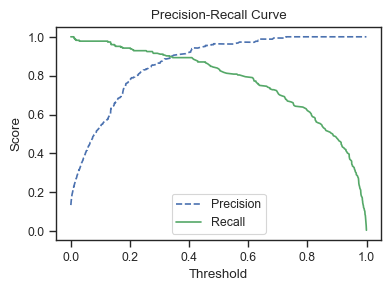

In [12]:
#| label: figure_pr_bayes
precision_recall_plot(y_test, y_pred_proba[:, 1])

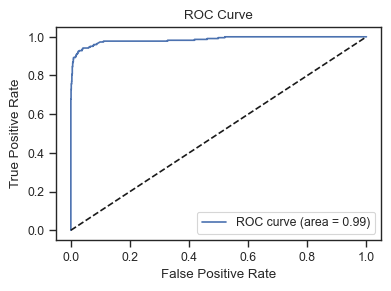

In [13]:
#| label: figure_roc_bayes
roc_plot(y_test, y_pred_proba[:, 1])

#### Logistic Regression

In [14]:
model_infos = models[1]
best_model = model_infos['best_model']
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

In [15]:
#| label: table_report_LR
table_report(y_test, y_pred)

,precision,recall,f1-score,support
ham,96.98%,99.72%,98.33%,1448
spam,97.81%,79.91%,87.96%,224
accuracy,,,97.07%,1672
macro avg,97.40%,89.82%,93.15%,1672
weighted avg,97.09%,97.07%,96.94%,1672


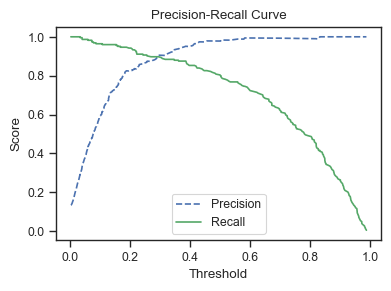

In [16]:
#| label: figure_pr_LR
precision_recall_plot(y_test, y_pred_proba[:, 1])

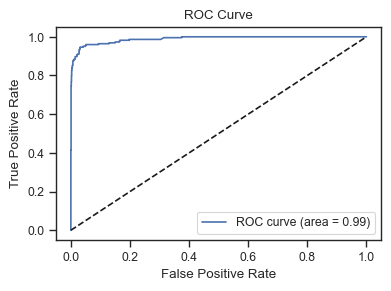

In [17]:
#| label: figure_roc_LR
roc_plot(y_test, y_pred_proba[:, 1])

#### Support-vector clustering

In [18]:
model_infos = models[2]
best_model = model_infos['best_model']
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

In [19]:
#| label: table_report_SVC
table_report(y_test, y_pred)

,precision,recall,f1-score,support
ham,98.10%,99.79%,98.94%,1448
spam,98.49%,87.50%,92.67%,224
accuracy,,,98.15%,1672
macro avg,98.30%,93.65%,95.81%,1672
weighted avg,98.15%,98.15%,98.10%,1672


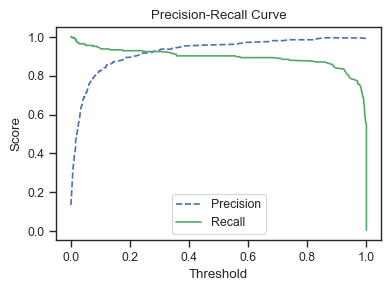

In [20]:
#| label: figure_pr_SVC
precision_recall_plot(y_test, y_pred_proba[:, 1])

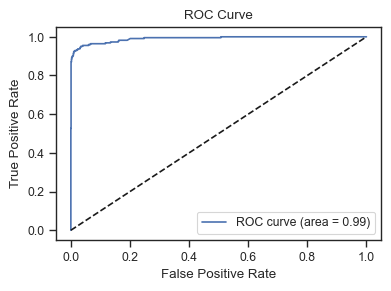

In [21]:
#| label: figure_roc_SVC
roc_plot(y_test, y_pred_proba[:, 1])

### Refit and save model

In [22]:
import pickle

DATA_FOLDER = Path('../data')

# Refit and save model
for model_infos in models:
    best_model = model_infos['best_model']
    best_model.fit(df['text'], df['is_spam'])
    
    with open(DATA_FOLDER / model_infos['model_filepath'], 'wb') as f:
        pickle.dump(best_model, f)

### Load and perform model inference 

Add a warning admonition :

The inference can only be performed when executing the notebook locally.

In [23]:
import ipywidgets as widgets
from IPython.display import display

# Load the saved model
model_filepath = Path('naive_bayes_model.pkl')  # Change this to the appropriate model file path
with open(DATA_FOLDER / model_filepath, 'rb') as f:
    loaded_model = pickle.load(f)

# Create an input widget
input_text = widgets.Textarea(
    value='',
    placeholder='Type something',
    description='Input:',
    disabled=False
)

# Create an output widget
output = widgets.Output()

# Define a function to perform inference
def on_text_submit(change):
    with output:
        output.clear_output()
        text = change['new']
        prediction_proba = loaded_model.predict_proba([text])
        print(f"Spam probability (between 0 and 1): {prediction_proba[0][1]*100:.2f}%")

# Bind the function to the input widget
input_text.observe(on_text_submit, names='value')

# Display the widgets
display(input_text, output)

Textarea(value='', description='Input:', placeholder='Type something')

Output()